In [20]:
!pytest -v test_bootstrap.py

============================= test session starts ==============================
platform darwin -- Python 3.6.5, pytest-3.6.1, py-1.5.3, pluggy-0.6.0 -- /anaconda/bin/python
cachedir: .pytest_cache
rootdir: /Users/John.Ciemniecki/git/bootcamp, inifile:
plugins: remotedata-0.3.0, openfiles-0.2.0, doctestplus-0.1.2, arraydiff-0.2
collected 8 items                                                              

test_bootstrap.py::test_2D_ndarray PASSED                                [ 12%]
test_bootstrap.py::test_string_dtype PASSED                              [ 25%]
test_bootstrap.py::test_list_dtype PASSED                                [ 37%]
test_bootstrap.py::test_array_NaN PASSED                                 [ 50%]
test_bootstrap.py::test_array_inf PASSED                                 [ 62%]
test_bootstrap.py::test_output_size PASSED                               [ 75%]
test_bootstrap.py::test_diff_func PASSED                                 [ 87%]
test_bootstrap.py::test_no_f

In [1]:
import bootstrap as boot
import pandas as pd
import numpy as np
import altair as alt
import bootcamp_utils

In [2]:
df = pd.read_csv('data/grant_complete.csv', comment='#')

In [3]:
df_1975 = df.loc[df['year']==1975]
df_1975.head()

,band,beak depth (mm),beak length (mm),species,year
89,2,8.0,9.4,fortis,1975
90,9,8.3,9.2,fortis,1975
91,12,7.5,9.5,fortis,1975
92,15,8.0,9.5,fortis,1975
93,305,9.9,11.5,fortis,1975


In [4]:
# Create ECDF for each species in the year 1975 using bootcamp_utils.ecdf_y
grouped = df_1975.groupby('species')
df_1975['ecdf_y grouped by species'] = grouped['beak depth (mm)'].transform(bootcamp_utils.ecdf_y)
df_1975.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,band,beak depth (mm),beak length (mm),species,year,ecdf_y grouped by species
89,2,8.0,9.4,fortis,1975,0.054487
90,9,8.3,9.2,fortis,1975,0.137821
91,12,7.5,9.5,fortis,1975,0.003205
92,15,8.0,9.5,fortis,1975,0.057692
93,305,9.9,11.5,fortis,1975,0.810897


In [5]:
# Create formal ECDF for each species in the year 1975 using bootcamp_utils.ecdf_dataframe
df_1975_ecdf = bootcamp_utils.ecdf_dataframe(df_1975, 'beak length (mm)', color='species', formal=True)
df_1975_ecdf.head()

,species,beak length (mm),ECDF
0,fortis,8.338,0.000000
1,fortis,8.700,0.000000
2,fortis,8.700,0.000000
3,fortis,8.700,0.003205
4,fortis,8.800,0.003205


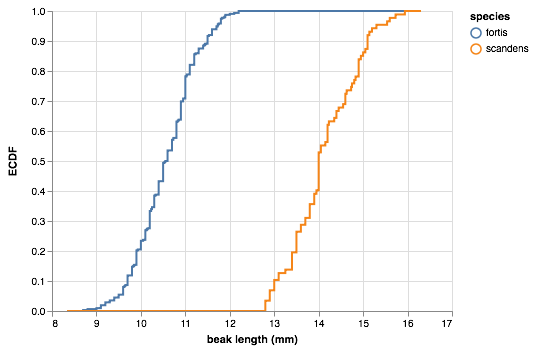

In [6]:
# Plot formal ECDF
formal_ecdf = alt.Chart(df_1975_ecdf,
                ).mark_line(
                ).encode(
                    x='beak length (mm):Q',
                    y='ECDF:Q',
                    color='species',
                    order='beak length (mm):Q'
)

formal_ecdf

In [86]:
# Draw bootstrap samples and populate dataframe with the samples
depth_fortis = df_1975.loc[df_1975['species']=='fortis','beak length (mm)'].values
depth_scandens = df_1975.loc[df_1975['species']=='scandens','beak length (mm)'].values

bs_depth_fortis = boot.draw_bs_reps(depth_fortis, 'beak length (mm)', func=None, size=10000)
bs_depth_scandens = boot.draw_bs_reps(depth_scandens, 'beak length (mm)', func=None, size=10000)
bs_depth_fortis.head()

,bs sample,beak length (mm),ecdf_y grouped by bs sample
0,0,10.7,0.557692
1,0,10.6,0.532051
2,0,11.2,0.830128
3,0,10.5,0.464744
4,0,12.0,0.996795


In [115]:
# fortis wrangling
bs_depth_fortis_max_ecdf = bs_depth_fortis.groupby('beak length (mm)')['ecdf_y grouped by bs sample']\
        .max().reset_index().rename(columns={'ecdf_y grouped by bs sample':'bs ecdf max'})
bs_depth_fortis_min_ecdf = bs_depth_fortis.groupby('beak length (mm)')['ecdf_y grouped by bs sample']\
        .min().reset_index().rename(columns={'ecdf_y grouped by bs sample':'bs ecdf min'})
bs_depth_fortis_min_max = pd.merge(bs_depth_fortis_max_ecdf, bs_depth_fortis_min_ecdf)

# scandens wrangling
bs_depth_scandens_max_ecdf = bs_depth_scandens.groupby('beak length (mm)')['ecdf_y grouped by bs sample']\
        .max().reset_index().rename(columns={'ecdf_y grouped by bs sample':'bs ecdf max'})
bs_depth_scandens_min_ecdf = bs_depth_scandens.groupby('beak length (mm)')['ecdf_y grouped by bs sample']\
        .min().reset_index().rename(columns={'ecdf_y grouped by bs sample':'bs ecdf min'})
bs_depth_scandens_min_max = pd.merge(bs_depth_scandens_max_ecdf, bs_depth_scandens_min_ecdf)

bs_depth_fortis_min_max.head()

,beak length (mm),bs ecdf max,bs ecdf min
0,8.7,0.019231,0.003205
1,8.8,0.028846,0.003205
2,9.0,0.032051,0.003205
3,9.1,0.054487,0.003205
4,9.2,0.073718,0.003205


Problem: the ECDF min and max values are not monotonic. Is this always a possibility of bootstrapping or is it a bug? No not possible. All ECDFs must be monotonic, including bootsatrapped ones, and so finding the min and max ECDF values in the samples must also result in a monotonic sequence. Must be a bug.

To troubleshoot, can keep the bootstrap sample ID number in the above df to trace. Need internet to search how to do this with split-apply-combine methods. Try .filter instead?

In [117]:
# fortis wrangling to try to include bs sample # in max ecdf dataframe [INCOMPLETE!!!]
bs_depth_fortis_max_ecdf = bs_depth_fortis.groupby('beak length (mm)').filter\
                            (bs_depth_fortis.groupby('beak length (mm)')['ecdf_y grouped by bs sample'].max())

bs_depth_fortis_max_ecdf.head()

TypeError: 'numpy.float64' object is not callable

In [92]:
# Plot the bootstrap points with opacity 0.3
alt.data_transformers.enable('default', max_rows=None)
bs_ecdf_fortis = alt.Chart(bs_depth_fortis_min_max,
                ).mark_area(
                    opacity=0.3
                ).encode(
                    x=alt.X('beak length (mm):Q'),
                    y=alt.Y('bs ecdf min:Q', title='ECDF'),
                    y2=alt.Y('bs ecdf max:Q',title='ECDF'),
                    order='beak length (mm):Q')

bs_ecdf_scandens = alt.Chart(bs_depth_scandens_min_max,
                ).mark_area(
                    color='orange',
                    opacity=0.3
                ).encode(
                    x=alt.X('beak length (mm):Q'),
                    y=alt.Y('bs ecdf min:Q',title='ECDF'),
                    y2=alt.Y('bs ecdf max:Q',title='ECDF'),
                    order='beak length (mm):Q')

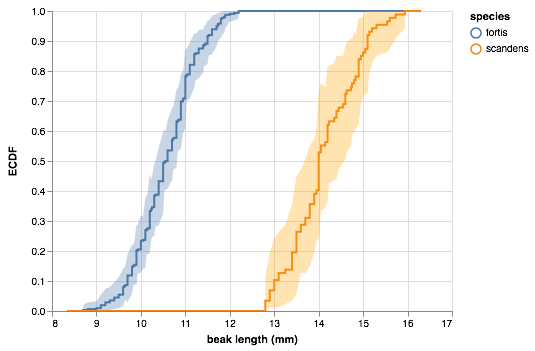

In [93]:
formal_ecdf + bs_ecdf_fortis + bs_ecdf_scandens

In [39]:
bs_depth_fortis = boot.draw_bs_reps(depth_fortis, 'beak length (mm)', size=10000)
bs_depth_scandens = boot.draw_bs_reps(depth_scandens, 'beak length (mm)', size=10000)

In [44]:
bs_depth_fortis_confidence = np.percentile(bs_depth_fortis, [2.5, 50.0, 97.5])
bs_depth_scandens_confidence = np.percentile(bs_depth_scandens, [2.5, 50.0, 97.5])

In [47]:
bs_depth_fortis_summary = pd.DataFrame(data={'fortis':bs_depth_fortis_confidence})
bs_depth_scandens_summary = pd.DataFrame(data={'scandens':bs_depth_scandens_confidence})
bs_depth_summary = pd.concat([bs_depth_fortis_summary,bs_depth_scandens_summary], axis=1).melt()
bs_depth_summary

,variable,value
0,fortis,10.487303
1,fortis,10.562131
2,fortis,10.635769
3,scandens,13.965172
4,scandens,14.120460
5,scandens,14.275517


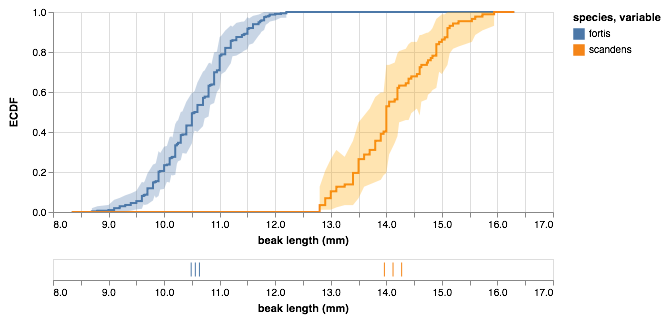

In [84]:
sum_ticks = alt.Chart(bs_depth_summary, width=500
                ).mark_tick(opacity=1
                ).encode(
                    x=alt.X('value:Q', title='beak length (mm)', scale=alt.Scale(domain=[8,17])),
                    color='variable'
                )
#line = alt.Chart().mark_rule().encode(x=8, x2=17)


alt.layer(formal_ecdf, bs_ecdf_fortis, bs_ecdf_scandens).properties(height=200, width=500) & sum_ticks

Something is wrong here. There should not be jagged ends because previous points set the min of subsequent points by definition.